The first step is to load all the required libraries and load raw data files into memory.

# Load Libraries

In [1]:
import numpy as np  
import pandas as pd   #numpy and pandas are the 2 most important libraries for Data Science.
#will add others as we go down the road
#basic libs for data vizualisations
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

# Load the raw data

In [2]:
sales = pd.read_csv('sales_train.csv')
shops = pd.read_csv('shops.csv')
items = pd.read_csv('items.csv')
item_cats = pd.read_csv('item_categories.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv("sample_submission.csv")

# Basic EDA

## Sales

In [3]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [4]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [5]:
sales['date'] = pd.to_datetime(sales.date,format='%d.%m.%Y')

In [6]:
sales.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [7]:
sales.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


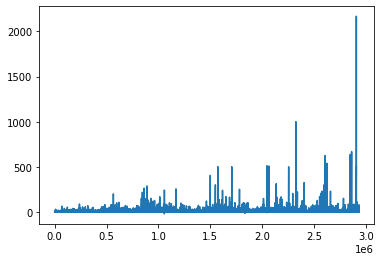

In [8]:
plt.plot(sales['item_cnt_day'])

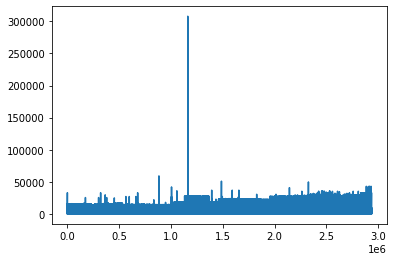

In [9]:
plt.plot(sales['item_price'])

Plot the total sale of each month, we see a clear trend and seasonality. The overall sale is decreasing with time, and there are peaks in November.

<AxesSubplot:xlabel='date_block_num'>

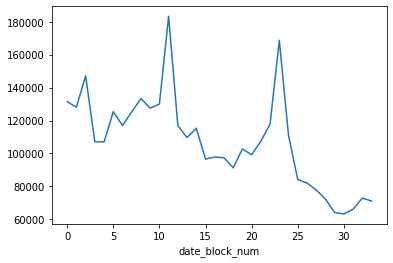

In [10]:
sale_by_month = sales.groupby('date_block_num')['item_cnt_day'].sum()
sale_by_month.plot()

Identified outliers in sales data from the above plots. As it is only a small number I have decided to get rid of it

In [11]:
sales[sales['item_price'] > 100000]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1163158,2013-12-13,11,12,6066,307980.0,1.0


In [12]:
sales[sales['item_cnt_day'] > 1000]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2909818,2015-10-28,33,12,11373,0.908714,2169.0


In [13]:
# get rid of outliers
sales = sales[sales['item_price']<100000]
sales = sales[sales['item_cnt_day']<1000]

The decribe shows there are rows with item_price and item_cnt_day >0, perhaps it is a missing value (which would be a bit strange tbh, because one could simply not insert the row). The other option is that these are returns of the product. Not sure if these should be counted in.

In [14]:
sales[sales['item_price'] < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,2013-05-15,4,32,2973,-1.0,1.0


There is one item with price below zero. Fill it with median

In [15]:
median = sales.item_price.median()
sales.loc[sales.item_price<0, 'item_price'] = median

In [16]:
# making a new column day
sales['day'] = sales['date'].dt.day

# making a new column month
sales['month'] = sales['date'].dt.month

# making a new column year
sales['year'] = sales['date'].dt.year

# making a new column week
sales['week'] = sales['date'].dt.week

# checking the new columns
sales.columns

<ipython-input-16-f7ba77e2dbba>:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  sales['week'] = sales['date'].dt.week


Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day', 'day', 'month', 'year', 'week'],
      dtype='object')

In [17]:
# calculate the sales store per month
sales['sales']=sales.item_price*sales.item_cnt_day

In [18]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,day,month,year,week,sales
0,2013-01-02,0,59,22154,999.00,1.0,2,1,2013,1,999.00
1,2013-01-03,0,25,2552,899.00,1.0,3,1,2013,1,899.00
2,2013-01-05,0,25,2552,899.00,-1.0,5,1,2013,1,-899.00
3,2013-01-06,0,25,2554,1709.05,1.0,6,1,2013,1,1709.05
4,2013-01-15,0,25,2555,1099.00,1.0,15,1,2013,3,1099.00


## Shops

In [19]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [20]:
shops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   shop_name  60 non-null     object
 1   shop_id    60 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


In [21]:
shops.duplicated('shop_name').sum()

0

In [22]:
shops['shop_name'].unique()

array(['!Якутск Орджоникидзе, 56 фран', '!Якутск ТЦ "Центральный" фран',
       'Адыгея ТЦ "Мега"', 'Балашиха ТРК "Октябрь-Киномир"',
       'Волжский ТЦ "Волга Молл"', 'Вологда ТРЦ "Мармелад"',
       'Воронеж (Плехановская, 13)', 'Воронеж ТРЦ "Максимир"',
       'Воронеж ТРЦ Сити-Парк "Град"', 'Выездная Торговля',
       'Жуковский ул. Чкалова 39м?', 'Жуковский ул. Чкалова 39м²',
       'Интернет-магазин ЧС', 'Казань ТЦ "Бехетле"',
       'Казань ТЦ "ПаркХаус" II', 'Калуга ТРЦ "XXI век"',
       'Коломна ТЦ "Рио"', 'Красноярск ТЦ "Взлетка Плаза"',
       'Красноярск ТЦ "Июнь"', 'Курск ТЦ "Пушкинский"',
       'Москва "Распродажа"', 'Москва МТРЦ "Афи Молл"',
       'Москва Магазин С21', 'Москва ТК "Буденовский" (пав.А2)',
       'Москва ТК "Буденовский" (пав.К7)', 'Москва ТРК "Атриум"',
       'Москва ТЦ "Ареал" (Беляево)', 'Москва ТЦ "МЕГА Белая Дача II"',
       'Москва ТЦ "МЕГА Теплый Стан" II',
       'Москва ТЦ "Новый век" (Новокосино)', 'Москва ТЦ "Перловский"',
       'Москва Т

In most of the cases 1st word on the shops names is a city:
Moscow [Москва]
Rostnone[]
etc
We are going to create a new feature with the city of a shop 


Also, there are some shops that appear to be the same one:
"Zhukovsky st. Chkalova 39m²" --> "Zhukovsky st. Chkalova 39m?"
"! Yakutsk Ordzhonikidze, 56 fran" --> "Yakutsk Ordzhonikidze, 56"
"! Yakutsk shopping center "Central" Fran" --> "Yakutsk shopping center "Central"
"Rostnone TRK "Megacentr Horizont" --> "Rostov on the Don TRK "Megcenter Horizon" island"

In [23]:
shops['city'] = shops['shop_name'].apply(lambda x: x.replace('!','').split()[0])

In [24]:
# As we saw on EDA some shops are duplicated w/distinct shop_id and shop_name
print(f'> {shops.iloc[0,0]} (id: {shops.iloc[0,1]})         <--->  \
{shops.iloc[57,0]} (id: {shops.iloc[57,1]})\n\
> {shops.iloc[1,0]} (id: {shops.iloc[1,1]}) <--->  \
{shops.iloc[58,0]} (id: {shops.iloc[58,1]})\n\
> {shops.iloc[10,0]} (id: {shops.iloc[10,1]})             <--->  \
{shops.iloc[11,0]} (id: {shops.iloc[11,1]})\n\
> {shops.iloc[39,0]} (id: {shops.iloc[39,1]})       <--->  \
{shops.iloc[40,0]} (id: {shops.iloc[40,1]})\n')

> !Якутск Орджоникидзе, 56 фран (id: 0)         <--->  Якутск Орджоникидзе, 56 (id: 57)
> !Якутск ТЦ "Центральный" фран (id: 1) <--->  Якутск ТЦ "Центральный" (id: 58)
> Жуковский ул. Чкалова 39м? (id: 10)             <--->  Жуковский ул. Чкалова 39м² (id: 11)
> РостовНаДону ТРК "Мегацентр Горизонт" (id: 39)       <--->  РостовНаДону ТРК "Мегацентр Горизонт" Островной (id: 40)



In [25]:
# We correct this cases
sales['shop_id'] = sales['shop_id'].replace({0: 57, 1: 58, 11: 10, 40: 39})
test['shop_id'] = test['shop_id'].replace({0: 57, 1: 58, 11: 10, 40: 39})

In [26]:
# Some of the shops that are in the sales dataframe are not in the Test set. 
# We Leak to improve predictions
shops_on_test = test['shop_id'].unique()
sales = sales[sales['shop_id'].isin(shops_on_test)]

## Items 

In [27]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [28]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   item_name         22170 non-null  object
 1   item_id           22170 non-null  int64 
 2   item_category_id  22170 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 519.7+ KB


In [29]:
items.duplicated('item_name').sum()

0

In [30]:
items['item_name'].unique()

array(['! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D',
       '!ABBYY FineReader 12 Professional Edition Full [PC, Цифровая версия]',
       '***В ЛУЧАХ СЛАВЫ   (UNV)                    D', ...,
       'Язык запросов 1С:Предприятия 8 (+CD). Хрусталева Е.Ю.',
       'Яйцо для Little Inu', 'Яйцо дракона (Игра престолов)'],
      dtype=object)

In [51]:
items['item_id'].nunique()

22170

In [53]:
items.shape

(22170, 4)

In [54]:
sales.shape

(2433534, 11)

In [60]:
Sales_per_item=sales.groupby("item_id").size().sort_values()

In [55]:
sales.shape[0]/items.shape[0]

109.76698240866035

In [58]:
shops.shape

(60, 3)

We have several items that only have one appearence in Train set

In [59]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,day,month,year,week,sales
0,2013-01-02,0,59,22154,999.00,1.0,2,1,2013,1,999.00
1,2013-01-03,0,25,2552,899.00,1.0,3,1,2013,1,899.00
2,2013-01-05,0,25,2552,899.00,-1.0,5,1,2013,1,-899.00
3,2013-01-06,0,25,2554,1709.05,1.0,6,1,2013,1,1709.05
4,2013-01-15,0,25,2555,1099.00,1.0,15,1,2013,3,1099.00


In [66]:
plt.(Sales_per_item,bins=300)

TypeError: scatter() missing 1 required positional argument: 'y'

In [86]:
Sales_per_item['cumsum']=Sales_per_item[0].cumsum()

<AxesSubplot:>

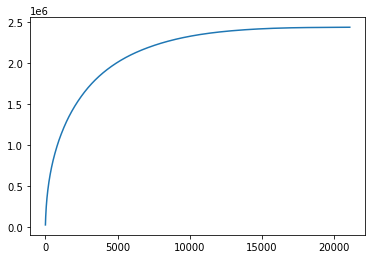

In [95]:
Sales_per_item['cumsum'].plot()

<AxesSubplot:>

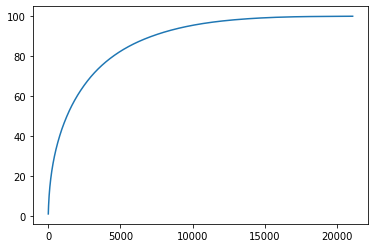

In [96]:
Sales_per_item['perc_cumsum'].plot()

In [78]:
Sales_per_item.sort_values(ascending=False,inplace=True)

In [84]:
Sales_per_item=pd.DataFrame(Sales_per_item)

In [94]:
Sales_per_item.head()

,item_id,0,cumsum,perc_cumsum
0,20949,26736,26736,1.098649
1,5822,7942,34678,1.425006
2,17717,7900,42578,1.749637
3,2808,6380,48958,2.011807
4,4181,5996,54954,2.258197


In [90]:
Sales_per_item=Sales_per_item.reset_index()

In [93]:
Sales_per_item['perc_cumsum']=(Sales_per_item['cumsum']/(Sales_per_item['cumsum'].max()))*100

In [32]:
# Create a feature with the 1st-ever-sale date for every item
items['first_sale_date'] = sales.groupby('item_id').agg({'date_block_num': 'min'})['date_block_num']
items['first_sale_date'] = items['first_sale_date'].fillna(34)

## Items_category

In [33]:
item_cats.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [34]:
item_cats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   item_category_name  84 non-null     object
 1   item_category_id    84 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


In [35]:
item_cats.duplicated('item_category_name').sum()

0

In [36]:
item_cats['item_category_name'].unique()

array(['PC - Гарнитуры/Наушники', 'Аксессуары - PS2', 'Аксессуары - PS3',
       'Аксессуары - PS4', 'Аксессуары - PSP', 'Аксессуары - PSVita',
       'Аксессуары - XBOX 360', 'Аксессуары - XBOX ONE', 'Билеты (Цифра)',
       'Доставка товара', 'Игровые консоли - PS2',
       'Игровые консоли - PS3', 'Игровые консоли - PS4',
       'Игровые консоли - PSP', 'Игровые консоли - PSVita',
       'Игровые консоли - XBOX 360', 'Игровые консоли - XBOX ONE',
       'Игровые консоли - Прочие', 'Игры - PS2', 'Игры - PS3',
       'Игры - PS4', 'Игры - PSP', 'Игры - PSVita', 'Игры - XBOX 360',
       'Игры - XBOX ONE', 'Игры - Аксессуары для игр',
       'Игры Android - Цифра', 'Игры MAC - Цифра',
       'Игры PC - Дополнительные издания',
       'Игры PC - Коллекционные издания', 'Игры PC - Стандартные издания',
       'Игры PC - Цифра', 'Карты оплаты (Кино, Музыка, Игры)',
       'Карты оплаты - Live!', 'Карты оплаты - Live! (Цифра)',
       'Карты оплаты - PSN', 'Карты оплаты - Windows (Цифра)',

Seems we can create a "major" level to aggregate some categories

In [37]:
# Create a major feature
item_cats['major'] = item_cats['item_category_name'].apply(lambda x: x.split()[0])

In [38]:
# Replace with 'etc' if category count is less than 5
item_cats['major'] = item_cats['major'].apply(lambda x: x if len(item_cats[item_cats['major']==x]) >= 5 else 'other')

## Test

In [39]:
test.head(5)

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [40]:
test.describe()

,ID,shop_id,item_id
count,214200.000000,214200.000000,214200.000000
mean,107099.500000,31.642857,11019.398627
std,61834.358168,17.561933,6252.644590
min,0.000000,2.000000,30.000000
25%,53549.750000,16.000000,5381.500000
50%,107099.500000,34.500000,11203.000000
75%,160649.250000,47.000000,16071.500000
max,214199.000000,59.000000,22167.000000


In [41]:
test.isnull().sum()

ID         0
shop_id    0
item_id    0
dtype: int64

In [42]:
test.groupby("item_id").size().sort_values().unique()

array([42])

In [43]:
test['item_id'].nunique()

5100

## Sample submission

In [44]:
sample_submission.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [45]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   ID              214200 non-null  int64  
 1   item_cnt_month  214200 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 3.3 MB


# Merging all data together

In [46]:
train= pd.merge(sales, items, on='item_id')

In [47]:
train= pd.merge(train, shops, on='shop_id')

In [48]:
train= pd.merge(train, item_cats, on='item_category_id')

In [49]:
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,day,month,year,week,sales,item_name,item_category_id,first_sale_date,shop_name,city,item_category_name,major
0,2013-01-02,0,59,22154,999.0,1.0,2,1,2013,1,999.0,ЯВЛЕНИЕ 2012 (BD),37,0.0,"Ярославль ТЦ ""Альтаир""",Ярославль,Кино - Blu-Ray,Кино
1,2013-04-26,3,59,944,150.0,1.0,26,4,2013,17,150.0,2012 (BD),37,0.0,"Ярославль ТЦ ""Альтаир""",Ярославль,Кино - Blu-Ray,Кино
2,2013-06-26,5,59,944,199.5,1.0,26,6,2013,26,199.5,2012 (BD),37,0.0,"Ярославль ТЦ ""Альтаир""",Ярославль,Кино - Blu-Ray,Кино
3,2013-07-20,6,59,944,199.5,1.0,20,7,2013,29,199.5,2012 (BD),37,0.0,"Ярославль ТЦ ""Альтаир""",Ярославль,Кино - Blu-Ray,Кино
4,2013-09-14,8,59,944,299.0,2.0,14,9,2013,37,598.0,2012 (BD),37,0.0,"Ярославль ТЦ ""Альтаир""",Ярославль,Кино - Blu-Ray,Кино
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2433529,2015-10-22,33,55,13093,250.0,1.0,22,10,2015,43,250.0,Карта оплаты Windows: 250 рублей [Цифровая вер...,36,31.0,Цифровой склад 1С-Онлайн,Цифровой,Карты оплаты - Windows (Цифра),Карты
2433530,2015-09-21,32,55,13091,1000.0,1.0,21,9,2015,39,1000.0,Карта оплаты Windows: 1000 рублей [Цифровая ве...,36,32.0,Цифровой склад 1С-Онлайн,Цифровой,Карты оплаты - Windows (Цифра),Карты
2433531,2015-09-16,32,55,13094,2500.0,1.0,16,9,2015,38,2500.0,Карта оплаты Windows: 2500 рублей [Цифровая ве...,36,32.0,Цифровой склад 1С-Онлайн,Цифровой,Карты оплаты - Windows (Цифра),Карты
2433532,2015-09-22,32,55,13094,2500.0,2.0,22,9,2015,39,5000.0,Карта оплаты Windows: 2500 рублей [Цифровая ве...,36,32.0,Цифровой склад 1С-Онлайн,Цифровой,Карты оплаты - Windows (Цифра),Карты
